In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from wordcloud import WordCloud
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization

np_config.enable_numpy_behavior()

In [72]:
df = pd.read_csv("/content/drive/MyDrive/translation/dataset.csv", header=None)


bangla_sentences = pd.DataFrame(df[1])
banglish_sentences = pd.DataFrame(df[0])


In [73]:
bangla_sentences.head()

,1
0,Human_Annotated_Bengali_Text
1,স্ক্রোল করে ২০/৩০ সেকেন্ড এর ভিডিও পান নাই???
2,ও গুলা টরেন্ট সাইট এ পাবেন
3,ভক্কর চক্কর পোস্ট একটা করলেই এপ্রুভড.… নিশ্চই ...
4,আমি টেস্ট করেই কোড দিছি…


In [74]:
banglish_sentences.head()

,0
0,Romanized_Text
1,scroll kore 20/30 second er video pann nai???
2,o gula Torrent site e paben
3,vokkor chokkor post akta korlei approved…. nis...
4,ami test koreii code disi…


In [75]:
bangla_sentences[1].values[1:]


array(['স্ক্রোল করে ২০/৩০ সেকেন্ড এর ভিডিও পান নাই???',
       'ও গুলা টরেন্ট সাইট এ পাবেন',
       'ভক্কর চক্কর পোস্ট একটা করলেই এপ্রুভড.… নিশ্চই  ঘাবলা আছে', ...,
       'অপেক্ষা করেন ', 'সময় আসবে', 'আমাদেরও সময় আসবে'], dtype=object)

In [76]:
banglish_sentences[0].values[1:]

array(['scroll kore 20/30 second er video pann nai???',
       'o gula Torrent site e paben',
       'vokkor chokkor post akta korlei approved…. nishchoi ghabla ache',
       ..., 'Opekkha koren', 'Shomoy ashbe', 'Amadero somoy ashbe'],
      dtype=object)

In [77]:
english_sentences =  bangla_sentences[1].values[1:]
bangla_sentences = banglish_sentences[0].values[1:]

In [78]:
for i in range(len(english_sentences)):
    english_sentences[i] = "sos " + str(english_sentences[i]) + " eos."
    bangla_sentences[i] = "sos " + str(bangla_sentences[i]) + " eos."

In [79]:
num_words = 10000
tokenizer_en = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_en.fit_on_texts(english_sentences)
english_sentences = tokenizer_en.texts_to_sequences(english_sentences)

word_index = tokenizer_en.word_index
print(f"The number of words in the English vocabulary: {len(word_index)}")

The number of words in the English vocabulary: 5686


In [80]:
tokenizer_fr = Tokenizer(num_words=num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer_fr.fit_on_texts(bangla_sentences)
bangla_sentences = tokenizer_fr.texts_to_sequences(bangla_sentences)

word_index_fr = tokenizer_fr.word_index
print(f"The number of words in the Bangla  vocabulary: {len(word_index_fr)}")

The number of words in the Bangla  vocabulary: 6554


In [81]:
english_sentences = pad_sequences(english_sentences, maxlen = 30, padding='post', truncating='post')
bangla_sentences = pad_sequences(bangla_sentences, maxlen=30, padding='post', truncating='post')

In [82]:
def get_angles(pos, i, embedding_dim):

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embedding_dim))
    return pos * angle_rates

In [83]:
def positional_encoding(position, embedding_dim):

    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(embedding_dim)[np.newaxis, :], embedding_dim)

    # apply sin to even indices in the array. ie 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array. ie 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

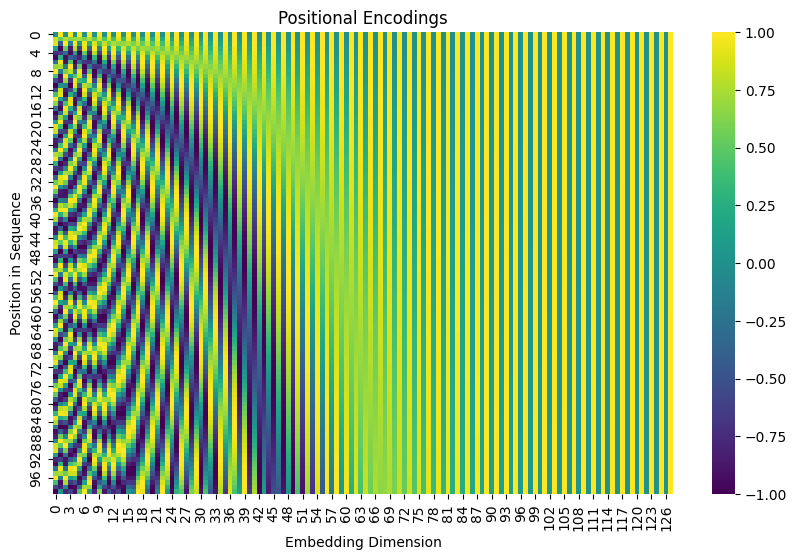

In [84]:
# Generate positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()


In [85]:
def create_padding_mask(seq):

    # Convert the sequence to a boolean tensor where True indicates a pad token (value 0).
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Add an extra dimension to the mask to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]


In [86]:
def create_look_ahead_mask(size):

    # create a matrix with ones on the diagonal and zeros below the diagonal
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

    return mask


In [87]:
def create_masks(inputs, targets):


    # Create the encoder padding mask.
    enc_padding_mask = create_padding_mask(inputs)

    # Create the decoder padding mask.
    dec_padding_mask = create_padding_mask(inputs)

    # Create the look ahead mask for the first attention block.
    # It is used to pad and mask future tokens in the tokens received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])

    # Create the decoder target padding mask.
    dec_target_padding_mask = create_padding_mask(targets)

    # Combine the look ahead mask and decoder target padding mask for the first attention block.
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [88]:
def scaled_dot_product_attention(q, k, v, mask):

    # Compute dot product of query and key vectors
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    # Compute the square root of the depth of the key vectors
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)

    # Compute scaled attention logits by dividing dot product by scaled dk
    scaled_attention_logits = matmul_qk / scaled_dk

    # Apply mask to the attention logits (if mask is not None)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Apply softmax to the scaled attention logits to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Compute the weighted sum of the value vectors using the attention weights
    output = tf.matmul(attention_weights, v)

    return output, attention_weights


In [89]:
class MultiHeadAttention(tf.keras.layers.Layer):


    def __init__(self, key_dim, num_heads, dropout_rate=0.0):

        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        #  ensure  that the dimension of the embedding can be evenly split across attention heads
        assert key_dim % num_heads == 0
        self.depth = self.key_dim // self.num_heads

        # dense layers to project the input into queries, keys and values
        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)

        # dropout layer
        self.dropout = Dropout(dropout_rate)

        # dense layer to project the output of the attention heads
        self.dense = Dense(key_dim)

    def split_heads(self, x, batch_size):

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):

        batch_size = tf.shape(q)[0]

        # Dense on the q, k, v vectors
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # split the heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # split the queries, keys and values into multiple heads
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # reshape and add Dense layer
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)

        return output, attention_weights


In [90]:
def FeedForward(embedding_dim, fully_connected_dim):

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])
    return model


In [91]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):

        super(EncoderLayer, self).__init__()

        # Multi-head self-attention mechanism
        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        # Dropout
        self.dropout = Dropout(dropout_rate)

        # Feedforward network
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)

    def call(self, x, training, mask):


        # Apply multi-head self-attention mechanism to input tensor
        attn_output, _ = self.mha(x, x, x, mask)

        # Apply first layer normalization and add residual connection
        out1 = self.layernorm1(attn_output + x)

        # Apply feedforward network to output of first layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)

        # Apply second layer normalization and add residual connection
        out2 = self.layernorm2(ffn_output + out1)

        return out2

In [92]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):

        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        # Embedding layer
        self.embedding = Embedding(input_vocab_size, embedding_dim)

        # Positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)

        # Encoder layers
        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]

        # Dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training, mask):


        # Get the sequence length
        seq_len = tf.shape(inputs)[1]

        # Embed the input sequence
        inputs = self.embedding(inputs)

        # Scale the embeddings by sqrt(embedding_dim)
        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encodings to the input sequence
        inputs += self.pos_encoding[:, :seq_len, :]

        # Apply dropout to the input sequence
        inputs = self.dropout(inputs, training=training)

        # Pass the input sequence through the encoder layers
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training, mask)

        # Return the encoded sequence
        return inputs

In [93]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):

        super(DecoderLayer, self).__init__()

        # Instantiate two instances of MultiHeadAttention.
        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        # Instantiate a fully connected feedforward network.
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)

        # Instantiate three layer normalization layers with epsilon=1e-6.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        # Instantiate a dropout layer for regularization.
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):


        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)

        # Add the original input to the output of the attention layer and apply layer normalization.
        out1 = self.layernorm1(attn1 + x)

        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)

        # Add the output from the first layer to the output of the second layer and apply layer normalization.
        out2 = self.layernorm2(attn2 + out1)

        # Apply the feedforward network to the output of the second layer and apply dropout regularization.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)

        # Add the output from the second layer to the output of the feedforward network and apply layer normalization.
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [94]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):

        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        # create layers
        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # apply each layer of the decoder
        for i in range(self.num_layers):
            # pass through decoder layer i
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            # record attention weights for block1 and block2
            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2

        return x, attention_weights

In [95]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout_rate=0.1):
        super(Transformer, self).__init__()

        # Initialize the Encoder and Decoder layers
        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_target, dropout_rate)

        # Add a final dense layer to make the final prediction
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        # Pass the input sequence through the Encoder
        enc_output = self.encoder(inp, training, enc_padding_mask)

        # Pass the target sequence and the output of the Encoder through the Decoder
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # Pass the output of the Decoder through the final dense layer to get the final prediction
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


## Initializing Hyperparameters <a name="5-1"></a>

In [96]:
# Set hyperparameters for the Transformer model
embedding_dim = 256  # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 512  # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 4  # number of Transformer blocks in the encoder and decoder stacks
num_heads = 8  # number of heads in the multi-head attention mechanism
dropout_rate = 0.1  # dropout rate for regularization

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(tokenizer_fr.word_index) + 2  # add 2 for the start and end tokens
target_vocab_size = len(tokenizer_en.word_index) + 2  # add 2 for the start and end tokens

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size  # maximum positional encoding value for input sequence
max_positional_encoding_target = target_vocab_size  # maximum positional encoding value for target sequence

# Set the number of epochs and batch size for training
EPOCHS = 200
batch_size = 256


In [97]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):

        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)


In [98]:
# Create an instance of the Transformer model
transformer = Transformer(num_layers, embedding_dim, num_heads,
                           fully_connected_dim, input_vocab_size, target_vocab_size,
                           max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2 = 0.98, epsilon = 1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(true_values, predictions):
    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Compute the loss value using the loss object
    loss_ = loss_object(true_values, predictions)

    # Apply the mask to exclude the padding tokens
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # Calculate the mean loss value
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_values, predictions):
    # Compute the accuracies using the true and predicted target sequences
    accuracies = tf.equal(true_values, tf.argmax(predictions, axis=2))

    # Create a mask to exclude the padding tokens
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Apply the mask to exclude the padding tokens from the accuracies
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    # Calculate the mean accuracy value
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define the training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [99]:

# the train function
train_step_signature = [
    tf.TensorSpec(shape=(batch_size, 30), dtype=tf.int64),
    tf.TensorSpec(shape=(batch_size,30), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(encoder_input, target):

    # Slice the target tensor to get the input for the decoder
    decoder_input = target[:, :-1]

    # Slice the target tensor to get the expected output of the decoder
    expected_output = target[:, 1:]

    # Create masks for the encoder input, decoder input and the padding
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # Perform a forward pass through the model
    with tf.GradientTape() as tape:
        predictions, _ = transformer(encoder_input, decoder_input, True, enc_padding_mask, combined_mask, dec_padding_mask)

        # Calculate the loss between the predicted output and the expected output
        loss = loss_function(expected_output, predictions)

    # Calculate gradients and update the model parameters
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update the training loss and accuracy metrics
    train_loss(loss)
    train_accuracy(expected_output, predictions)



In [100]:
epoch_losses = []
epoch_accuracies = []
for epoch in range(1, EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    current_batch_index = 0

    # iterate through the dataset in batches of batch_size
    for i in range(int(len(english_sentences)/batch_size)):
        # get the input and target batch
        target_batch = tf.convert_to_tensor(np.array(english_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)
        input_batch = tf.convert_to_tensor(np.array(bangla_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)

        current_batch_index = current_batch_index + batch_size
        # call the train_step function to train the model using the current batch
        train_step(input_batch, target_batch)

    epoch_losses.append(train_loss.result().numpy())
    epoch_accuracies.append(train_accuracy.result().numpy())
    # print the epoch loss and accuracy after iterating through the dataset
    print (f'Epoch {epoch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

Epoch 1 Loss 8.3325 Accuracy 0.0044
Epoch 2 Loss 7.5887 Accuracy 0.5906
Epoch 3 Loss 6.6688 Accuracy 0.7282
Epoch 4 Loss 5.9246 Accuracy 0.7282
Epoch 5 Loss 5.4295 Accuracy 0.7282
Epoch 6 Loss 5.1004 Accuracy 0.7282
Epoch 7 Loss 4.8309 Accuracy 0.7282
Epoch 8 Loss 4.5688 Accuracy 0.7282
Epoch 9 Loss 4.2959 Accuracy 0.7282
Epoch 10 Loss 4.0101 Accuracy 0.7282
Epoch 11 Loss 3.7165 Accuracy 0.7282
Epoch 12 Loss 3.4244 Accuracy 0.7282
Epoch 13 Loss 3.1479 Accuracy 0.7282
Epoch 14 Loss 2.9044 Accuracy 0.7282
Epoch 15 Loss 2.7083 Accuracy 0.7282
Epoch 16 Loss 2.5622 Accuracy 0.7282
Epoch 17 Loss 2.3777 Accuracy 0.7282
Epoch 18 Loss 2.1704 Accuracy 0.7291
Epoch 19 Loss 2.0489 Accuracy 0.7579
Epoch 20 Loss 1.9686 Accuracy 0.7623
Epoch 21 Loss 1.9113 Accuracy 0.7623
Epoch 22 Loss 1.8649 Accuracy 0.7620
Epoch 23 Loss 1.8206 Accuracy 0.7617
Epoch 24 Loss 1.7824 Accuracy 0.7623
Epoch 25 Loss 1.7580 Accuracy 0.7625
Epoch 26 Loss 1.7352 Accuracy 0.7636
Epoch 27 Loss 1.7207 Accuracy 0.7639
Epoch 28 L

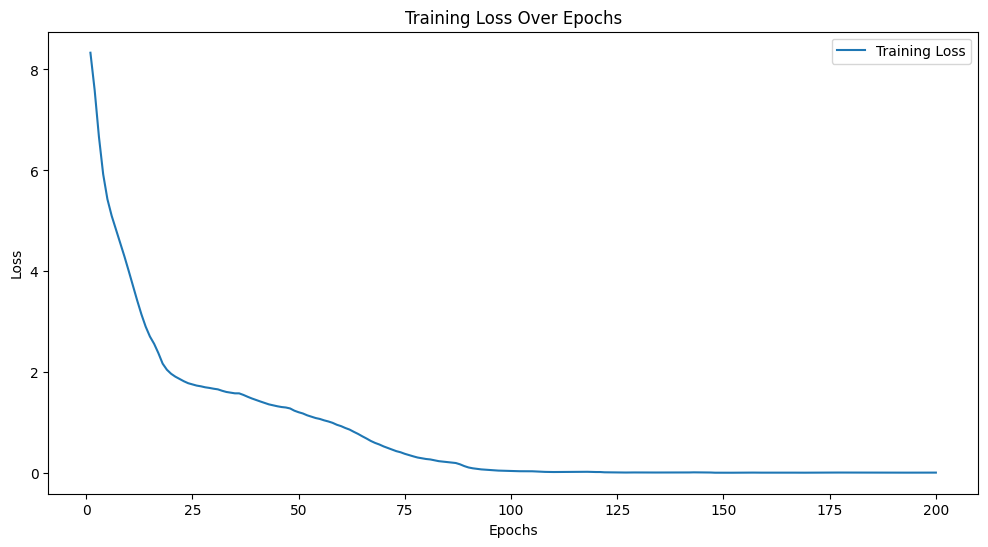

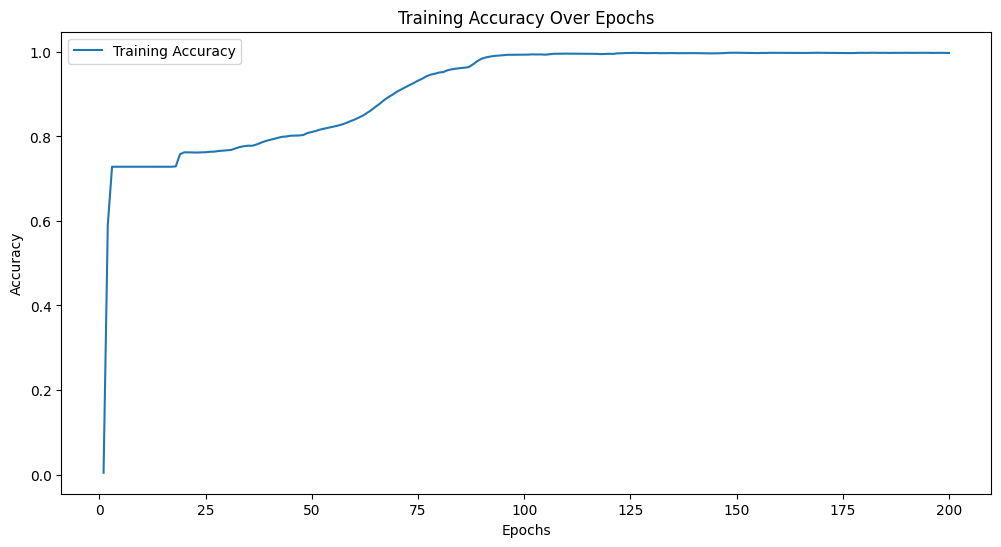

In [101]:
import matplotlib.pyplot as plt


# Plotting the loss graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS+1), epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS+1), epoch_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [102]:
maxlen = 30
def translate_helper(sentence):
    sentence = 'sos ' + sentence[0] + ' eos.' # Add start and end of sentence markers
    sentence = [sentence] # Convert sentence to list because of TensorFlow's tokenizer

    # Vectorize and pad the sentence
    sentence = tokenizer_fr.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=30, padding='post', truncating='post')
    input = tf.convert_to_tensor(np.array(sentence),dtype=tf.int64) # Convert input to tensor

    # Tokenize the start of the decoder input and convert it to a tensor
    decoder_input = tokenizer_en.texts_to_sequences(['sos'])
    decoder_input = tf.convert_to_tensor(np.array(decoder_input), dtype=tf.int64)

    # Generate the translated sentence
    for i in range(maxlen):
        # Create masks for the encoder, decoder, and combined
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input, decoder_input)
        # Generate predictions for the current input sequence
        predictions, _ = transformer(input, decoder_input,False,enc_padding_mask,combined_mask, dec_padding_mask)
        # Select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]
        # Get the predicted word ID by taking the argmax of the predictions
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)

        # If the predicted ID is equal to the end token, return the decoder input
        if predicted_id == tokenizer_en.texts_to_sequences(['eos']):
            return tf.squeeze(decoder_input, axis=0)

        # Concatenate the predicted ID to the output which is given to the decoder
        # as its input.
        decoder_input = tf.concat([decoder_input, predicted_id], axis=1)

    # Return the translated sentence
    return tf.squeeze(decoder_input, axis=0)


## Translate Function <a name="6-2"></a>

In [103]:
def translate(sentence):
    sentence = [sentence]
    print(f'Input sentence: {sentence[0]}')
    print()
    result = (translate_helper(sentence)).tolist()
    predicted_ids = [i for i in result if i != tokenizer_en.texts_to_sequences(['sos'])[0][0]
                     and i != tokenizer_en.texts_to_sequences(['eos.'])[0][0]]

    predicted_sentence = tokenizer_en.sequences_to_texts([predicted_ids])
    print(f'Translation: {predicted_sentence[0]}')



In [104]:
sentence = "last duita comment dhut trickbd te react option nai naile akai 100 ta kore ha ha ditam ar vai post datha parle eidao post koren ki bhabe mobile er screen on korte hoi onek helpfull hoto"
output = translate(sentence)

Input sentence: last duita comment dhut trickbd te react option nai naile akai 100 ta kore ha ha ditam ar vai post datha parle eidao post koren ki bhabe mobile er screen on korte hoi onek helpfull hoto

Translation: লাস্ট দুইটা কমেন্ট ধুত ট্রিকবিডি তে রিয়েক্ট অপশন নাই নাইলে একাই ১০০ টা করে হা হা দিতাম আর ভাই পোস্ট দাতা পারলে এইডাও পোস্ট করেন কি ভাবে মোবাইল এর এইডাও


In [105]:
sentence = "ami test koreii code disi"
translate(sentence)

Input sentence: ami test koreii code disi

Translation: আমি টেস্ট করেই কোড দিছি


In [106]:
sentence = "amar nam ki?"
translate(sentence)

Input sentence: amar nam ki?

Translation: আমার নাম কি?


In [117]:
sentence = "O hariye gese "
translate(sentence)

Input sentence: O hariye gese 

Translation: ও হারিয়ে গেছে


In [118]:
sentence = "tomar tate ki"
translate(sentence)

Input sentence: tomar tate ki

Translation: তোমার তাতে কি


In [120]:
sentence = "tumi bujho na ami bujhi"
translate(sentence)

Input sentence: tumi bujho na ami bujhi

Translation: তুমি না আমি বুঝি


In [122]:
sentence = "taratari den bhai"
translate(sentence)

Input sentence: taratari den bhai

Translation: তাড়াতাড়ি দেন ভাই


In [125]:
sentence = "dhur ami ar ekhane nai"
translate(sentence)

Input sentence: dhur ami ar ekhane nai

Translation: ধুর আমি আর এখানে নাই


In [ ]:
sentence = "tumi koi"
translate(sentence)

Input sentence: tumi koi

